<a href="https://colab.research.google.com/github/ssabrut/knee-arthritis-detection/blob/main/Annotated_Dataset_for_Knee_Arthritis_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import files

# # upload your kaggle.json API
# uploaded = files.upload()

In [2]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
# !kaggle datasets download -d hafiznouman786/annotated-dataset-for-knee-arthritis-detection

In [4]:
from IPython.display import clear_output

# !unzip annotated-dataset-for-knee-arthritis-detection.zip
# clear_output()

In [5]:
# !pip install -qq -U tensorflow-addons
# !pip install --upgrade keras-cv
# clear_output()

In [6]:
class Const:
  SEED = 42

class Hyperparameter:
  BUFFER_SIZE = 128
  BATCH_SIZE = 64
  IMAGE_SIZE = 72
  PATCH_SIZE = 6
  NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
  LEARNING_RATE = 0.001
  WEIGHT_DECAY = 0.0001
  EPOCHS = 50
  LAYER_NORM_EPS = 1e-6
  TRANSFORMER_LAYERS = 2
  PROJECTION_DIM = 16
  NUM_HEADS = 2
  TRANSFORMER_UNITS = [PROJECTION_DIM * 2, PROJECTION_DIM]
  MLP_HEAD_UNITS = [512, 256]

In [7]:
from tensorflow import keras

keras.utils.set_random_seed(Const.SEED)

In [8]:
from PIL import Image

width, height = Image.open('/content/Training/0Normal/NormalG0 (1).png').size
print('Image width:', width)
print('Image height:', height)

Image width: 300
Image height: 162


In [9]:
import numpy as np

def extract_data(generator):
  images = []
  labels = []
  for image, label in generator:
    images.append(image)
    labels.append(label)
  return np.array(images), keras.utils.to_categorical(labels)

In [10]:
generator = keras.utils.image_dataset_from_directory('Training', image_size=(height, width)).unbatch().shuffle(Hyperparameter.BUFFER_SIZE)
images, labels = extract_data(generator)

Found 1650 files belonging to 5 classes.


In [11]:
print('Total images:', len(images))
print('Total labels:', len(labels))

Total images: 1650
Total labels: 1650


In [12]:
def plot_images(generator):
  plt.figure(figsize=(18, 7))
  for i, (image, label) in enumerate(generator.take(18)):
    ax = plt.subplot(3, 6, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(label.numpy())
    plt.axis("off")

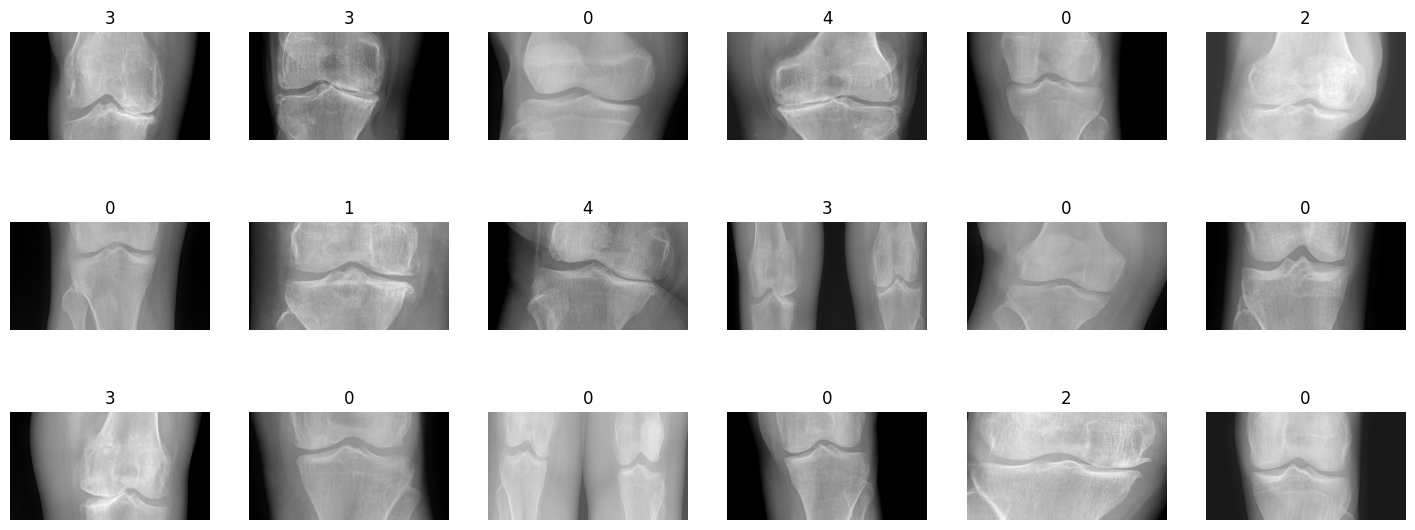

In [13]:
from matplotlib import pyplot as plt

# display random image from each class
plot_images(generator)

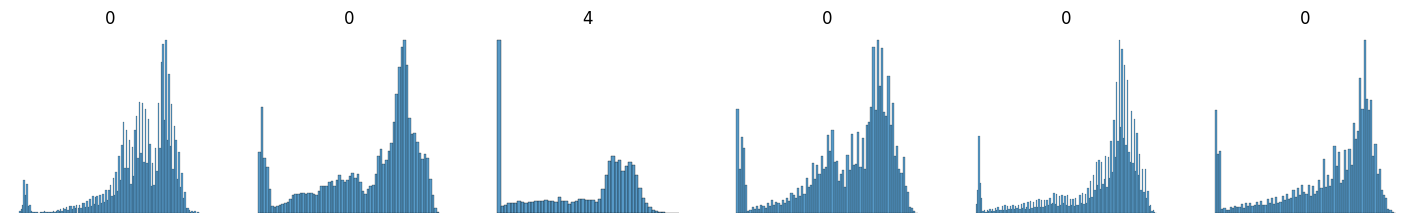

In [14]:
import seaborn as sns

# plot the histogram from each image to see the pixel distribution
plt.figure(figsize=(18, 8))
for i, (image, label) in enumerate(generator.take(6)):
  ax = plt.subplot(3, 6, i + 1)
  flat_image = image.numpy().flatten().astype("uint8")
  sns.histplot(flat_image, ax=ax)
  plt.title(label.numpy())
  ax.axis("off")
plt.show()

# Image Processing

In [15]:
import keras_cv

he = keras_cv.layers.Equalization((0,255))
he_generator = generator.map(lambda x, y: (he(x), y))

Using TensorFlow backend


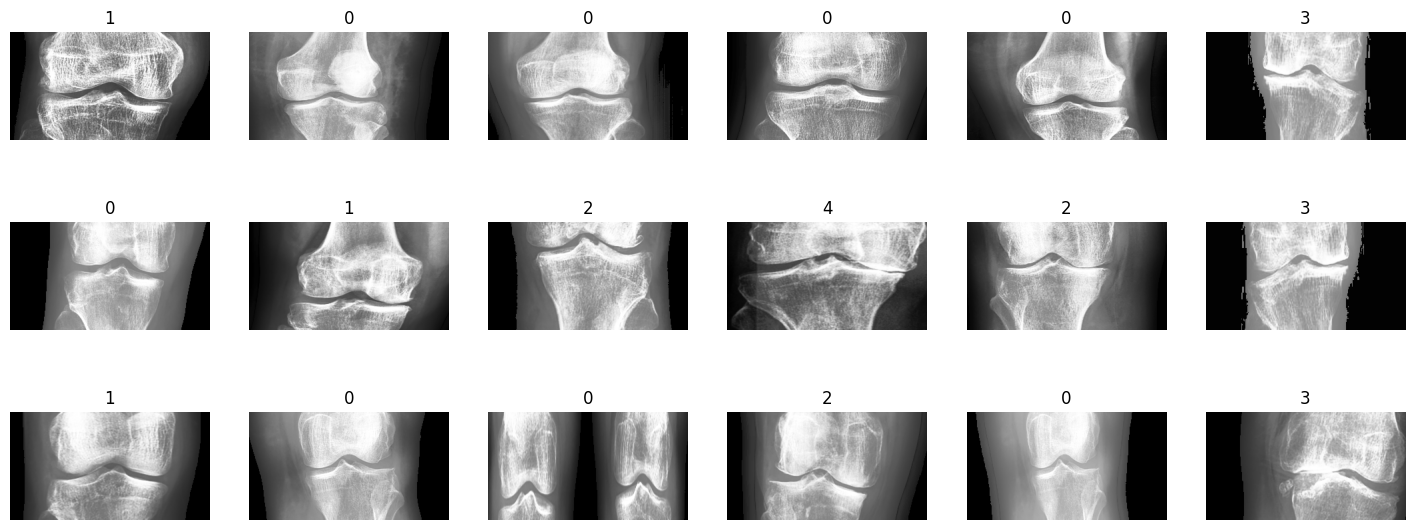

In [16]:
plot_images(he_generator)

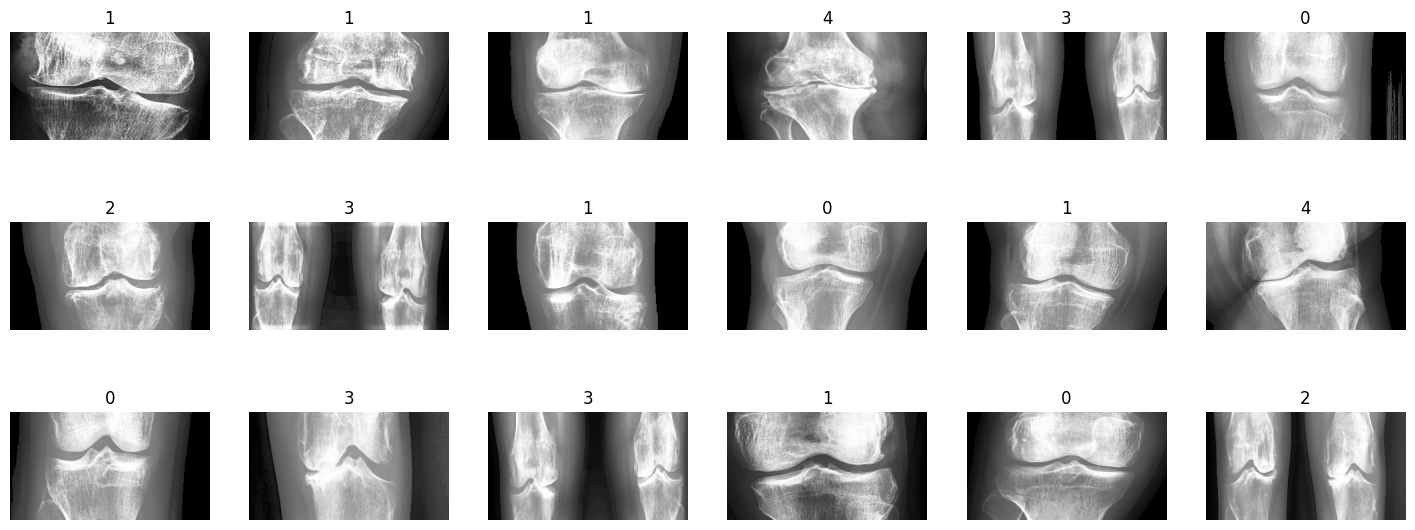

In [17]:
plot_images(he_generator)

# Preprocessing

In [18]:
from sklearn.model_selection import train_test_split

image_train, image_test, label_train, label_test = train_test_split(images, labels, test_size=.1, random_state=Const.SEED)
image_train, image_val, label_train, label_val = train_test_split(image_train, label_train, test_size=.2, random_state=Const.SEED)

In [19]:
print('Total images for training:', len(image_train))
print('Total images for validation:', len(image_val))
print('Total images for testing:', len(image_test))

Total images for training: 1188
Total images for validation: 297
Total images for testing: 165


In [20]:
print('Total label for training:', len(label_train))
print('Total label for validation:', len(label_val))
print('Total label for testing:', len(label_test))

Total label for training: 1188
Total label for validation: 297
Total label for testing: 165


# Augmentation

In [21]:
from keras import layers
import tensorflow as tf

data_augmentation = keras.Sequential([
    layers.Normalization(),
    layers.Resizing(Hyperparameter.IMAGE_SIZE, Hyperparameter.IMAGE_SIZE),
    layers.RandomFlip("horizontal")
], name='data_augmentation')

data_augmentation.layers[0].adapt(tf.concat([tf.stack(image_train), tf.stack(image_val)], axis=0))

In [26]:
class ShiftedPatchTokenization(layers.Layer):
  def __init__(
      self,
      image_size=Hyperparameter.IMAGE_SIZE,
      patch_size=Hyperparameter.PATCH_SIZE,
      num_patches=Hyperparameter.NUM_PATCHES,
      projection_dim=Hyperparameter.PROJECTION_DIM,
      vanilla=False,
      **kwargs
  ):
    super().__init__(**kwargs)
    self.image_size = image_size
    self.vanilla = vanilla
    self.patch_size = patch_size
    self.half_patch = self.patch_size // 2
    self.flatten_patches = layers.Reshape((num_patches, -1))
    self.projection = layers.Dense(units=projection_dim)
    self.layer_norm = layers.LayerNormalization(epsilon=Hyperparameter.LAYER_NORM_EPS)

  def crop_shift_pad(self, images, mode):
    if mode == "left-up":
        crop_height = self.half_patch
        crop_width = self.half_patch
        shift_height = 0
        shift_width = 0
    elif mode == "left-down":
        crop_height = 0
        crop_width = self.half_patch
        shift_height = self.half_patch
        shift_width = 0
    elif mode == "right-up":
        crop_height = self.half_patch
        crop_width = 0
        shift_height = 0
        shift_width = self.half_patch
    else:
        crop_height = 0
        crop_width = 0
        shift_height = self.half_patch
        shift_width = self.half_patch

    # Crop the shifted images and pad them
    crop = tf.image.crop_to_bounding_box(
        images,
        offset_height=crop_height,
        offset_width=crop_width,
        target_height=self.image_size - self.half_patch,
        target_width=self.image_size - self.half_patch,
    )
    shift_pad = tf.image.pad_to_bounding_box(
        crop,
        offset_height=shift_height,
        offset_width=shift_width,
        target_height=self.image_size,
        target_width=self.image_size,
    )
    return shift_pad

  def call(self, images):
    if not self.vanilla:
        # Concat the shifted images with the original image
        images = tf.concat(
            [
                images,
                self.crop_shift_pad(images, mode="left-up"),
                self.crop_shift_pad(images, mode="left-down"),
                self.crop_shift_pad(images, mode="right-up"),
                self.crop_shift_pad(images, mode="right-down"),
            ],
            axis=-1,
        )
    # Patchify the images and flatten it
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    flat_patches = self.flatten_patches(patches)
    if not self.vanilla:
        # Layer normalize the flat patches and linearly project it
        tokens = self.layer_norm(flat_patches)
        tokens = self.projection(tokens)
    else:
        # Linearly project the flat patches
        tokens = self.projection(flat_patches)
    return (tokens, patches)

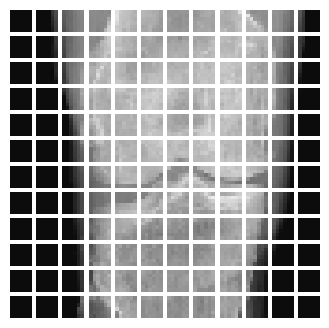

ORIGINAL


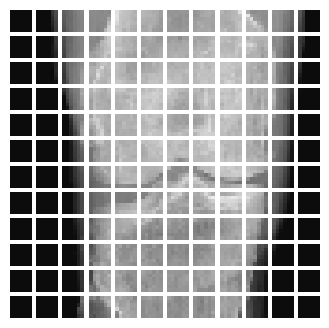

LEFT-UP


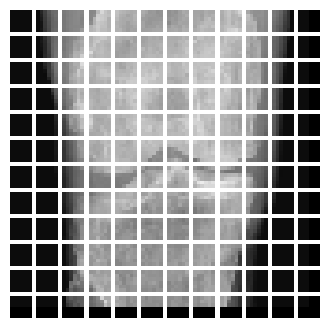

LEFT-DOWN


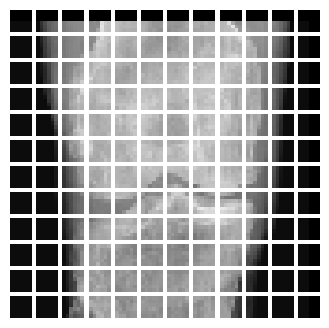

RIGHT-UP


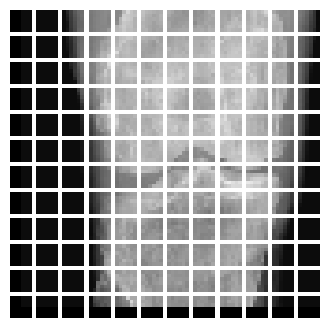

RIGHT-DOWN


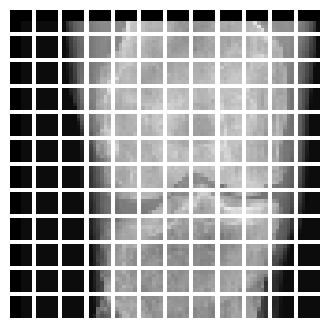

In [27]:
# Get a random image from the training dataset
# and resize the image
image = images[np.random.choice(range(images.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(Hyperparameter.IMAGE_SIZE, Hyperparameter.IMAGE_SIZE)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (Hyperparameter.PATCH_SIZE, Hyperparameter.PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (Hyperparameter.PATCH_SIZE, Hyperparameter.PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

In [28]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches=Hyperparameter.NUM_PATCHES, projection_dim=Hyperparameter.PROJECTION_DIM, **kwargs):
    super().__init__(**kwargs)
    self.num_patches = num_patches
    self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
    self.position = tf.range(start=0, limit=self.num_patches, delta=1)

  def call(self, encoded_patches):
    encoded_positions = self.position_embedding(self.positions)
    encoded_patches = encoded_patches + encoded_positions
    return encoded_patches